In [10]:
#setup the matplotlib graphics library and configure it to show
# figures inline in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
from numpy import *
# make qutip available in the rest of the notebook
from qutip import *
from matplotlib import animation as animation, pyplot as plt, cm
from IPython import display 
from IPython.display import HTML
#from scipy.integrate import simpson, cumtrapz



def Opera(dim,S):
    if S==1:
        jj=jmat(1)
        jx,jy,jz=jmat(1)
        jp=jmat(1,'+')
        jm=jmat(1,'-')
        sx = tensor(qeye(dim), jx)
        sy = tensor(qeye(dim), jy)
        sz = tensor(qeye(dim), jz)
        sm = tensor(qeye(dim), jm)
        sp = sm.dag()
        a = tensor(destroy(dim), qeye(3))
        ad = a.dag()
        ids = tensor(qeye(dim), qeye(3))
    else:
        
        sx = tensor(qeye(dim), sigmax())
        sy = tensor(qeye(dim), sigmay())
        sz = tensor(qeye(dim), sigmaz())
        sm = tensor(qeye(dim), sigmam())
        sp = sm.dag()
        a = tensor(destroy(dim), qeye(2))
        ad = a.dag()
        ids = tensor(qeye(dim), qeye(2))
        
    return sm, sp, sx, sy, sz, a, ad, ids


def drive_coeff(t, args):
    return Omega * exp(-1j * delta * t)

def drive_coeff_conj(t, args):
    return conj(Omega) * exp(1j * delta * t)


def drive_sq(t, args):
    return Omegap * exp(-2j * wp * t)

def drive_sq_conj(t, args):
    return conj(Omegap) * exp(2j * wp * t)




def compute_expectations(states, observables):
    """
    Compute the expectation values of given observables for a list of states.
    
    Parameters:
    - states: A list of Qobj states, typically the result of a mesolve.
    - observables: A list of Qobj observables for which to compute expectation values.
    
    Returns:
    - A list of lists, where each sublist contains the expectation values of an observable over time.
    """
    # Initialize a list to store the expectation values for each observable
    expectation_values = [[] for _ in observables]

    # Loop over each state
    for state in states:
        # Loop over each observable
        for i, obs in enumerate(observables):
            # Calculate and store the expectation value
            expectation_values[i].append(qutip.expect(obs, state))

    return expectation_values


def generate_c_ops(gammam, gammas, gammaa, gamma_l, n_th_a, sp_th_a, a, sz, sm, sp, include_lasing=False):
    """
    Generate collapse operators based on provided rates and conditions.
    
    Parameters:
    - gammam: Rate for cavity relaxation and excitation.
    - gammas: Rate for qubit relaxation.
    - gammaa: Rate for additional qubit dynamics.
    - gamma_l: Rate for lasing.
    - n_th_a: Thermal occupation number for cavity.
    - sp_th_a: Thermal occupation number for qubit.
    - a: Annihilation operator for the cavity.
    - sz, sm, sp: Pauli operators or equivalent for the qubit.
    - include_lasing: Boolean to include lasing in the collapse operators.
    
    Returns:
    - A list of collapse operators.
    """
    c_ops = []
    # Cavity relaxation
    rate = gammam * (1 + n_th_a)
    if rate > 0.0:
        c_ops.append(sqrt(rate) * a)
    # Cavity excitation, if temperature > 0
    rate = gammam * n_th_a
    if rate > 0.0:
        c_ops.append(sqrt(rate) * a.dag())
    # Qubit relaxation
    rate = gammas
    if rate > 0.0:
        c_ops.append(sqrt(rate) * sz)
    rate = gammaa * (1 + sp_th_a)
    if rate > 0.0:
        c_ops.append(sqrt(rate) * sm)
    rate = gammaa * sp_th_a
    if rate > 0.0:
        c_ops.append(sqrt(rate) * sp)
    # Lasing
    if include_lasing:
        rate = gamma_l
        if rate > 0.0:
            c_ops.append(sqrt(rate) * sm)
    
    return c_ops



def plot_wigner_functions(all_states, times, all_times, mode='a', xvec=linspace(-15, 15, 200)):
    """
    Plot Wigner functions for specified states at given times.

    :param all_states: Concatenated states from all phases of evolution.
    :param mode: 'a' for the resonator or 's' for the spin.
    :param times: Array of times to plot Wigner functions for.
    :param xvec: Phase space range for Wigner function calculation.
    """
    for t in times:
        # Find the closest time index
        index = (abs(all_times - t)).argmin()
        rho = all_states[index]
        
        # Trace out the appropriate mode
        if mode == 'a':
            rho_reduced = rho.ptrace(0)  # For resonator
        elif mode == 's':
            rho_reduced = rho.ptrace(1)  # For spin
        else:
            raise ValueError("Invalid mode. Use 'a' or 's'.")

        # Calculate the Wigner function
        W = wigner(rho_reduced, xvec, xvec)

        # Plotting
        plt.figure(figsize=(8, 6))
        plt.contourf(xvec, xvec, W, 100, cmap='RdBu', norm=plt.Normalize(-0.1, 0.1))
        plt.colorbar()
        plt.title(f'Wigner function of mode {mode} at t={t:.2f}')
        plt.xlabel('Quadrature X')
        plt.ylabel('Quadrature P')
        plt.show()
        
        

def plot_hist(all_states, times, all_times, num_ticks=10, tick_rotation=90, figsize=(12, 6), tick_spacing=5):
    """
    Plot the histogram of state populations over time with specified x-ticks.

    Parameters:
    - all_states: List of Qobj states to plot.
    - times: List of times corresponding to each state.
    - num_ticks: Number of x-ticks to display on the plot. Default is 10.
    - tick_rotation: Degree of rotation for x-ticks. Default is 90.
    - figsize: Tuple representing the figure size. Default is (12, 6).
    - tick_spacing: Number of states between ticks on x-axis. Default is 5.
    """
    plt.figure(figsize=figsize)

    for t in times:
        
        index = (abs(all_times - t)).argmin()
        rho = all_states[index]
        # Assume 'state' is a Qobj for a density matrix, and we need the diagonal
        rho_reduced = rho.ptrace(0)  # Adjust if tracing over a different subsystem
        populations = rho_reduced.diag()

        # Prepare the figure
        plt.clf()  # Clear the current figure
        plt.bar(arange(len(populations)), populations)

        # Set the x-ticks to be sparse based on tick_spacing
        plt.xticks(arange(0, len(populations), tick_spacing), rotation=tick_rotation)

        # Labeling the plot
        plt.title(f'Population histogram at t={t:.2f}')
        plt.xlabel('State')
        plt.ylabel('Population')
        plt.draw()  # Draw the current frame
        plt.pause(0.1)  # Pause briefly to display the plot

    plt.show()
# Example usage
# Assuming 'all_states' is a list of QuTiP Qobj states and 'times' is a list of time points
# plot_hist(all_states, times)


def compute_heat_from_liouvillian(d_rho_dt, H, times):
    # Compute the trace of the product at each time step
    trace_values = [trace(d_rho_dt[i].full().dot(H.full())).real for i in range(len(times))]
    
    # Use the cumulative trapezoidal rule for numerical integration
    Q_t = cumtrapz(trace_values, times, initial=0)
    return Q_t



def plot_heat_contributions(Q_list, t):
    plt.figure(figsize=(12, 6))
    for i, Q in enumerate(Q_list):
        plt.plot(t[:len(Q)], Q, label=f'Contribution {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Heat contribution')
    plt.legend()
    plt.show()

    
    
def evolst(H, psi0, t, cops, observables):
    opts = Options(store_states=True)
    result = mesolve(H, psi0, t, cops, [], args={}, options=opts)
    exp_vals = compute_expectations(result.states, observables)
    
    return result, exp_vals





def Cyclevol(rho0, hamiltonian_time_pairs, c_ops_list, observables):
    """
    Perform a sequence of time evolutions on an initial state with different Hamiltonians
    and return individual heat contributions for each term in the collapse operators.

    Parameters:
    - rho0: Initial state (Qobj)
    - hamiltonian_time_pairs: List of tuples (H, tlist) for each evolution segment
    - c_ops_list: List of lists of collapse operators corresponding to each Hamiltonian
    - observables: List of observables (Qobj) to compute expectation values

    Returns:
    - all_states: Concatenated list of states from all evolution segments
    - all_times: Concatenated array of time points from all evolution segments
    - all_exp_vals: Concatenated expectation values for each observable over time
    - EntropyM: List of von Neumann entropy values for mechanical part over time
    - EntropyS: List of von Neumann entropy values for spin part over time
    - total_Q_terms_list: List of lists of individual heat contributions for each term in the collapse operators
    """
    all_states = []
    all_times = array([])
    all_exp_vals = [[] for _ in observables]
    current_state = rho0
    EntropyM = []
    EntropyS = []
    total_Q_terms_list = None  # Changed to None for clearer initialization logic

    for i, ((H, tlist), c_ops) in enumerate(zip(hamiltonian_time_pairs, c_ops_list)):
#         result, exp_vals, Q_terms = evolst(H, current_state, tlist, c_ops, observables)
        result, exp_vals = evolst(H, current_state, tlist, c_ops, observables)

        all_states.extend(result.states)

        if i == 0:
            all_times = array(tlist)
        else:
            # Ensure continuity in time by adding the last time from all_times
            all_times = concatenate((all_times, all_times[-1] + tlist))

        for j, exp_val in enumerate(exp_vals):
            all_exp_vals[j].extend(exp_val)

        for state in result.states:
            EntropyM.append(entropy_vn(state.ptrace(0), base=e))
            EntropyS.append(entropy_vn(state.ptrace(1), base=e))

        current_state = result.states[-1]

    return all_states, all_times, all_exp_vals, EntropyM, EntropyS


# def wtp(t, args):
#     return wt*t + wm
# # def wtm(t, args):
# #     return wt*(t-T) + wm

# def wtm(t, args):
#     return wt*(T-t)+ wm

# def gtm(t, args):
#     return g*sqrt(wm/abs(wt*(T-t) + wm))
# def gtp(t, args):
#     return g*sqrt(wm/abs(wt*t + wm))

def wtp(t, args):
    return wt*(t-T) + wm
# def wtm(t, args):
#     return wt*(t-T) + wm

def wtm(t, args):
    return -wt*t+ wm

def gtm(t, args):
    return g*sqrt(wm/abs(-wt*t + wm))
def gtp(t, args):
    return g*sqrt(wm/abs(wt*(t-T) + wm))


def Temperature(ni,wi):
    return (wi/kb)/(log(1+1/ni))


def CycleCool(rho0, hamiltonian_time_pairs, c_ops_list, observables, Ncycles):
    
    current_rho = rho0
    t=array([0])
    allst=[current_rho]
    rho_mech = current_rho.ptrace(0)
    rho_spin = current_rho.ptrace(1)
    EntropyM=[entropy_vn(rho_mech, base=e)]
    EntropyS=[entropy_vn(rho_spin, base=e)]
    
   
    
    for i in range(Ncycles):
        
#         if i==0:
#              t=array([0])
        rhot = current_rho.ptrace(0)
        rhoc, tt, exp_vals, entropyM, entropyS = Cyclevol(current_rho, hamiltonian_time_pairs, c_ops_list, observables)    
        EntropyM=concatenate((EntropyM,entropyM), axis=0)
        EntropyS=concatenate((EntropyS,entropyS), axis=0)
        allst=allst+rhoc
        t=concatenate((t, tt + (t[-1] if i > 0 else 0)))

        current_rho=rhoc[-1]
        print(i)
    
    return t, allst, EntropyM, EntropyS

[314.1592653589793, 218.42247457202683, 0.30826190431090367]


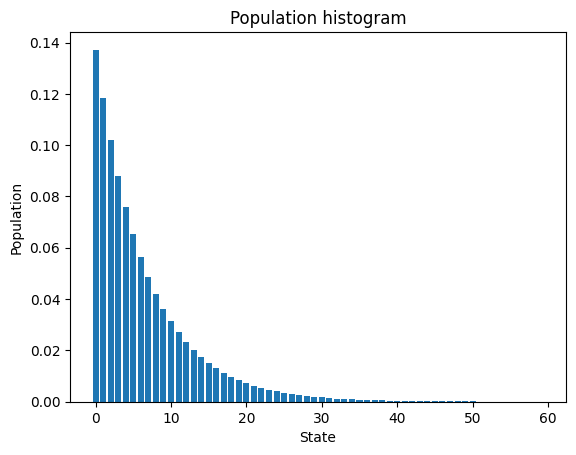

In [16]:
N =60
S=0.5

kb= 20836619120 
wt = 14000
T= 1*pi/(2*pi*50)
wm =50 * 2 * pi +wt*T
# fx = 0.5*wm;
fy =  1*10**(6)
g  =  0.4*wm#3e10 *1e-9* 2 * pi*.22


wmin=(-wt*T + wm)
gmin=g*sqrt(wm/(-wt*T + wm))
fx = 0.5*wmin;
Delta=5.8*wmin

print([wt*(0-T) + wm,gmin,wt*T/wm])

######### Operators ##################
sm, sp, sx, sy, sz, a, ad, ids=Opera(N,S)
z = a+ad
p = 1j*(ad-a)
z2 = z**2
p2 = p**2


######### Damping rates for each mode
Qm=10000
gammam = 1*wm/Qm
# gammam = 1*10**(-1)
gammas = 1/(2.5*10**(-3))
gammaa = 1/(5*10**(-3))
gamma_l = 1/(10**(-6))
n_th_a = 6     # avg number of thermal bath excitation
sp_th_a= 0.0001
n_th = n_th_a

c_ops1 = generate_c_ops(gammam, gammas, gammaa, gamma_l, n_th_a, sp_th_a, a, sz, sp, sm, include_lasing=False)
c_ops2 = generate_c_ops(gammam, gammas, gammaa, gamma_l, n_th_a, sp_th_a, a, sz, sp, sm, include_lasing=True)


######### Time evolutions ########


Tpy = pi/(4*abs(fy))
tfree = 1*pi/wmin 
tlase=1*10**(-6)

# T = tfree + Tpy + tlase
twm=linspace(0,T,500)
tpy = linspace(0, Tpy, 50)
tf1 = linspace(0, tfree, 200)
tgl = linspace(0, tlase, 50)


######## Hamiltonians
H    = Delta*(ids-sz)/2 + wm*ad*a - g*(ids-sz)*(a+ad)/2 
Hmin = Delta*(ids-sz)/2 + wmin*ad*a - gmin*(ids-sz)*(a+ad)/2

H0tp = [ad*a, wtp]
H0tm = [ad*a, wtm]

Hintp =[0.5*(ids-sz)*(a+ad) , gtp]
Hintm =[0.5*(ids-sz)*(a+ad) , gtm]

Hp = [ Delta*(ids-sz)/2, H0tp, Hintp]
Hm = [ Delta*(ids-sz)/2, H0tm, Hintm]


Hseq=[(Hmin+fx*sx, tf1), (Hmin, tgl)]
c_ops_seq = [c_ops1, c_ops2]

# Hseq=[(Hmin - fy*sy+fx*sx, tpy), (Hmin+fx*sx, tf1), (Hmin+fx*sx, tgl)]
# c_ops_seq = [c_ops1, c_ops1, c_ops2]



observables =  [ad*a, z, p, z2, p2, a, a**2, 0.5*(1-sz), sx, sy, Hmin, H]


rho1=steadystate(Hmin, c_ops1)
exp1=compute_expectations([rho1], observables)

# Assume 'state' is a Qobj for a density matrix, and we need the diagonal
rho_reduced = rho1.ptrace(0)  # Adjust if tracing over a different subsystem
populations = rho_reduced.diag()

# Prepare the figure
plt.clf()  # Clear the current figure
plt.bar(arange(len(populations)), populations)


# Labeling the plot
plt.title(f'Population histogram')
plt.xlabel('State')
plt.ylabel('Population')
plt.draw()  # Draw the current frame

plt.show()


In [18]:
t, allst, EntropyM, EntropyS = CycleCool(rho1, Hseq, c_ops_seq, observables, 10)
nph, zm, pm, z2m, p2m, am, a2m, ns, sxm, sym, Emin, Em = compute_expectations(allst, observables)
nph3 = nph[-1]
S3 = EntropyM [-1]
rho3=allst[-1]
exp3=compute_expectations([rho3], observables)

0
1
2
3
4
5
6
7
8
9


In [5]:
rho1=steadystate(H, c_ops1)
exp1=compute_expectations([rho1], observables)

result, exp_vals = evolst(Hm, rho1, twm, c_ops1, observables)
rho2 = result.states
exp2 = compute_expectations([rho2[-1]], observables)

E2t = []
n2t = []
S2t = []

for ii, state in enumerate(rho2):
    tt = twm[ii]  # Get the current time
    
    # Evaluate the Hamiltonian at the current time
    Hm_t = Hm[0] + Hm[1][0] * Hm[1][1](tt, None) + Hm[2][0] * Hm[2][1](tt, None)
    # Compute the expectation values
    E2t.append(qutip.expect(Hm_t, state))
    n2t.append(qutip.expect(ad * a, state))
    
    # Compute the von Neumann entropy
    S2t.append(entropy_vn(state.ptrace(0), base=e))

    
##########################
resultsd = {
    "nph": {},
    "EntropyM": {},
    "Emin": {},
    "n4t": {},
    "E4t": {},
    "S4t": {},
    "n5t": {},
    "E5t": {},
    "S5t": {}
}
# Ncool = [5,10,20,50,70,110,150,200,250,300,350,400]
# Ncool = [1,2,3,4,5,6,7,8,9,10,15,20,25,30]
# Ncool = [1,2,4,6,8,10,12,15,20,30]
# Ncool = [2,5,10,15]
# Ncool = [5,10,20,50,70,110,150]


Ncool = [10,20,50,300]

tss = linspace(0,200,35000)

for i, ntimes in enumerate(Ncool):
    print(ntimes)
    t, allst, EntropyM, EntropyS = CycleCool(rho2[-1], Hseq, c_ops_seq, observables, ntimes)
    nph, zm, pm, z2m, p2m, am, a2m, ns, sxm, sym, Emin, Em = compute_expectations(allst, observables)
    nph3 = nph[-1]
    S3 = EntropyM [-1]
    rho3=allst[-1]
    exp3=compute_expectations([rho3], observables)



    E4t = []
    n4t = []
    S4t = []
    result, exp_vals = evolst(Hp, rho3, twm, c_ops1, observables)
    rho4=result.states
    exp4=compute_expectations([rho4[-1]], observables)
    


    for ii, state in enumerate(rho4):
        tt = twm[ii]  # Get the current time

        # Evaluate the Hamiltonian at the current time
        Hp_t = Hp[0] + Hp[1][0] * Hp[1][1](tt, None) + Hp[2][0] * Hp[2][1](tt, None)

      
        # Compute the expectation values
        E4t.append(qutip.expect(Hp_t, state))
        n4t.append(qutip.expect(ad * a, state))    
        # Compute the von Neumann entropy
        S4t.append(entropy_vn(state.ptrace(0), base=e))
    
    # Store results in the dictionary
        resultsd["nph"][ntimes] = nph
        resultsd["EntropyM"][ntimes] = EntropyM
        resultsd["Emin"][ntimes] = Emin
        resultsd["n4t"][ntimes] = n4t
        resultsd["E4t"][ntimes] = E4t
        resultsd["S4t"][ntimes] = S4t

        
    
    result, exp_vals = evolst(H, rho4[-1], tss, c_ops1, observables)
    rho55=result.states
    E5t = []
    n5t = []
    S5t = []

    for ii, state in enumerate(rho55):
    #     tt = tss[ii]  # Get the current time


        # Compute the expectation values
        E5t.append(qutip.expect(H, state))
        n5t.append(qutip.expect(ad * a, state))

        # Compute the von Neumann entropy
        S5t.append(entropy_vn(state.ptrace(0), base=e))
        
        resultsd["n5t"][ntimes] = n5t
        resultsd["E5t"][ntimes] = E5t
        resultsd["S5t"][ntimes] = S5t
        
# rho5=steadystate(H, c_ops1)
# exp5=compute_expectations([rho5], observables)


# E5t = []
# n5t = []
# S5t = []
# E5t.append(qutip.expect(H, rho5))
# n5t.append(qutip.expect(ad * a, rho5))

# # Compute the von Neumann entropy
# S5t.append(entropy_vn(rho5.ptrace(0), base=e))





10
0
1
2
3
4
5
6
7
8
9
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
50
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
300
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221